In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

#plt.rcParams['figure.dpi'] = 150
import glob, os, json

from sklearn.decomposition import PCA

import scipy.stats as st
import timeit
import pickle

# Download HMMER data from the 5 batch jobs using the `03_download_hmmer.py` script

```console
python3 03_download_hmmer.py Data/PFAM_1 498 "https://www.ebi.ac.uk/Tools/hmmer/download/C89D6018-CF04-11EC-9B2E-CE02DCC3747A."

python3 03_download_hmmer.py Data/PFAM_2 499 "https://www.ebi.ac.uk/Tools/hmmer/download/0FA10BC6-CF06-11EC-B9A1-9E64E976C163."

python3 03_download_hmmer.py Data/PFAM_3 498 "https://www.ebi.ac.uk/Tools/hmmer/download/1E071650-CF07-11EC-8237-159953F04F9B."

python3 03_download_hmmer.py Data/PFAM_4 500 "https://www.ebi.ac.uk/Tools/hmmer/download/8EA0FB46-CF08-11EC-8CCE-9F64E976C163."

python3 03_download_hmmer.py Data/PFAM_5 137 "https://www.ebi.ac.uk/Tools/hmmer/download/15B613C2-CF0A-11EC-B9ED-F99853F04F9B."
```

# Combine HMMER data for each protein in a batch using `04_process_hmmer.py`

```console
python3 04_process_hmmer.py Data/PFAM_1 Data/proteins_seq_small_1.fasta Data/batch_1

python3 04_process_hmmer.py Data/PFAM_2 Data/proteins_seq_small_2.fasta Data/batch_2

python3 04_process_hmmer.py Data/PFAM_3 Data/proteins_seq_small_3.fasta Data/batch_3

python3 04_process_hmmer.py Data/PFAM_4 Data/proteins_seq_small_4.fasta Data/batch_4

python3 04_process_hmmer.py Data/PFAM_5 Data/proteins_seq_small_5.fasta Data/batch_5
```

# 7 Proteins longer than 5000 had to be queried using their UniProt ID

## Following esults determined manually

Q63HN8: 1 zf-C3HC4, 1 DUF6539

Q09666: 0 (only disordered and low complexity regions)

Q9NU22: 8 AAA_5, 3 AAA_lid_7, 1 AAA_lid_5

P58107: 36 Plectin

Q03001: 2 CH, 20 Spectrin, 1 SH3_10, 1 Spectrin_like, 1 Plectin, 1 EF-hand_7, 1 GAS2

Q86UQ4: 2 ABC2_membrane_3, 2 ABC_tran

Q8NF91: 2 CH, 10 Spectrin, 1 KASH

<b>If a results file is not present in the expected directory, it means that no domains were found.</b>

## Encode them in dataframes as follows (done already and combined with the main dataframe):

In [2]:
# df_1 = pd.DataFrame({'UniProt': ['Q63HN8', 'Q63HN8'], 'PFAM': ['zf-C3HC4', 'DUF6539'], 'Count': [1, 1]})

# df_2 = pd.DataFrame({'UniProt': ['Q9NU22', 'Q9NU22', 'Q9NU22'], 'PFAM': ['AAA_5', 'AAA_lid_7', 'AAA_lid_5'], 'Count': [8, 3, 1]})

# df_3 = pd.DataFrame({'UniProt': ['P58107'], 'PFAM': ['Plectin'], 'Count': [36]})

# df_4 = pd.DataFrame({'UniProt': ['Q03001', 'Q03001', 'Q03001', 'Q03001', 'Q03001', 'Q03001', 'Q03001'], 'PFAM': ['CH', 'Spectrin', 'SH3_10', 'Spectrin_like', 'Plectin', 'EF-hand_7', 'GAS2'], 'Count': [2, 20, 1, 1, 1, 1, 1]})

# df_5 = pd.DataFrame({'UniProt': ['Q86UQ4', 'Q86UQ4'], 'PFAM': ['ABC2_membrane_3', 'ABC_tran'], 'Count': [2, 2]})

# df_6 = pd.DataFrame({'UniProt': ['Q8NF91', 'Q8NF91', 'Q8NF91'], 'PFAM': ['CH', 'Spectrin', 'KASH'], 'Count': [2, 10, 1]})

# files = glob.glob("../Data/batch_*.csv")
# dfs_lst = [pd.read_csv(f) for f in files]

# final = pd.concat([pd.concat(dfs_lst), df_1, df_2, df_3, df_4, df_5, df_6])

# final.to_csv("../Processed/protein_domains.csv", index=False)

In [3]:
df = pd.read_csv("../Processed/protein_domains.csv")
print(df.shape)
print(f"{len(df.UniProt.unique())} proteins")

(5165, 3)
2081 proteins


# Distribution of Protein Domains in the dataset

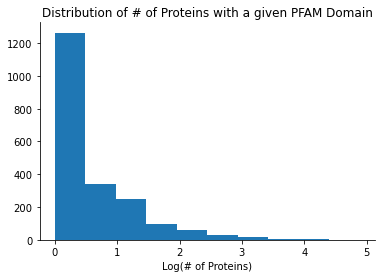

In [4]:
# count the number of proteins containing a given domain
summary_df = pd.DataFrame(df.groupby("PFAM")["UniProt"].count()).sort_values("UniProt", ascending=False).reset_index()
plt.hist(np.log(summary_df["UniProt"]))

plt.title("Distribution of # of Proteins with a given PFAM Domain")
plt.xlabel("Log(# of Proteins)")
sns.despine()
plt.show()

# Unsupervised Methods

## Principal Components Analysis -- not very informative b/c of such low explained variance and poor clustering

### No significant Spearman correlations between domains and PCs

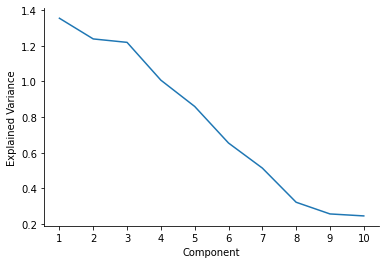

In [5]:
# first check using the elbow method
n = 10

# use the whole matrix for now
data = df.pivot(index="UniProt", columns="PFAM", values="Count").fillna(0).astype(int)

pca_large = PCA(n_components=n).fit(data.values)

plt.plot(np.arange(1, n+1), pca_large.explained_variance_)
sns.despine()
plt.xticks(np.arange(1, n+1))
plt.xlabel("Component")
plt.ylabel("Explained Variance")
plt.show()

In [6]:
# check that no proteins or domains have 0 representation
sum(data.sum(axis=1)==0), sum(data.sum(axis=1)==0)

(0, 0)

Explained variances: [1.35499293 1.23873102]


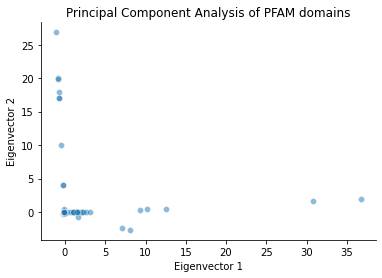

In [7]:
pca = PCA(n_components=2).fit(data.values)

print(f"Explained variances: {pca.explained_variance_}")

pca_transformed = pca.transform(data.values)

pca_df = pd.DataFrame(pca_transformed)

pca_df.columns = ["PC1", "PC2"]

pca_df["UniProt"] = data.index

sns.scatterplot(data=pca_df, x="PC1", y="PC2", alpha=0.5)

plt.title("Principal Component Analysis of PFAM domains")
plt.xlabel("Eigenvector 1")
plt.ylabel("Eigenvector 2")
sns.despine()
plt.savefig("../Figures/PFAM_pca.png", dpi=150)

In [8]:
def domain_spearman_df(data, pca_df):
    
    # compute Spearman correlations between every column in the dataframe and the principal components
    spearman_res_pc1 = [st.spearmanr(pca_df["PC1"], data.iloc[:, i]) for i in range(len(data.columns))]
    spearman_res_pc2 = [st.spearmanr(pca_df["PC2"], data.iloc[:, i]) for i in range(len(data.columns))]
    
    corrs_1, pvals_1 = list(zip(*spearman_res_pc1))
    corrs_2, pvals_2 = list(zip(*spearman_res_pc2))
    
    # return a dataframe of the results
    return pd.DataFrame({"Domain": data.columns, "Spearman_PC1": corrs_1, "pvals_PC1": pvals_1, "Spearman_PC2": corrs_2, "pvals_PC2": pvals_2})

In [9]:
pc_correlations = domain_spearman_df(data, pca_df)

# Look for inverse correlations between the principal components for the outliers

In [10]:
# positively correlated with PC1, negatively correlated with PC2
pc_correlations.query("pvals_PC1<0.05 & pvals_PC2<0.05 & Spearman_PC1>0 & Spearman_PC2<0").sort_values("Spearman_PC1", ascending=False)

,Domain,Spearman_PC1,pvals_PC1,Spearman_PC2,pvals_PC2
818,KH_1,0.185295,1.573604e-17,-0.111448,3.453538e-07
819,KH_2,0.069613,1.485243e-03,-0.054160,1.347388e-02
897,Ldl_recept_a,0.065421,2.828723e-03,-0.065840,2.656167e-03
898,Ldl_recept_b,0.065421,2.828732e-03,-0.065840,2.656175e-03
441,DUF1897,0.052429,1.676182e-02,-0.044745,4.125461e-02


In [11]:
data.index[np.where(data["DUF1897"]>0)[0]]

Index(['Q92945', 'Q96AE4'], dtype='object', name='UniProt')

## DUF1897 is a domain of unknown function

The two proteins it is present in (Q92945, Q96AE4) are likely DNA-binding transcriptional regulators, but they're not well characterized.

In [12]:
ldl_proteins = data.index[np.array(list(set(np.where(data["Ldl_recept_a"]>0)[0]).union(np.where(data["Ldl_recept_b"]>0)[0])))]
ldl_proteins

Index(['P98164', 'Q07954', 'Q14114'], dtype='object', name='UniProt')

In [13]:
virus_human = pd.read_csv("../Processed/virus_human.csv")
virus_human.loc[virus_human["Protein B"].isin(ldl_proteins)]

,Protein A,Protein B,Method,Publication,Taxid A,Taxid B,Interaction type,Source DB,Interaction identifier,Confidence,...,Protein B DB,Taxname A,Taxname B,superkingdom,phylum,class,order,family,genus,species
620,K9N7C7-PRO_0000422439,P98164,"psi-mi:""MI:0676""(tandem affinity purification)",pubmed:34232536|imex:IM-29365,1263720,9606,"psi-mi:""MI:0914""(association)","psi-mi:""MI:0469""(IntAct)",intact:EBI-27129420|imex:IM-29365-15,intact-miscore:0.35,...,uniprotkb,Betacoronavirus England 1,Homo sapiens,Viruses,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Middle East respiratory syndrome-related coron...
8915,P0DTC3,Q14114,"psi-mi:""MI:0007""(anti tag coimmunoprecipitation)",pubmed:33845483|pmc:PPR177217|doi:10.1101/2020...,2697049,9606,"psi-mi:""MI:0914""(association)","psi-mi:""MI:0469""(IntAct)",intact:EBI-25686340|imex:IM-28109-51,intact-miscore:0.35,...,uniprotkb,Severe acute respiratory syndrome coronavirus 2,Homo sapiens,Viruses,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...
11554,P0DTC3,P98164,"psi-mi:""MI:1313""(proximity labelling technology)",pubmed:34232536|imex:IM-29365,2697049,9606,"psi-mi:""MI:2364""(proximity)","psi-mi:""MI:0469""(IntAct)",intact:EBI-27128270|imex:IM-29365-169,intact-miscore:0.27,...,uniprotkb,Severe acute respiratory syndrome coronavirus 2,Homo sapiens,Viruses,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Severe acute respiratory syndrome-related coro...
12402,P0C6X6-PRO_0000283826,P98164,"psi-mi:""MI:0676""(tandem affinity purification)",pubmed:34232536|imex:IM-29365,31631,9606,"psi-mi:""MI:0914""(association)","psi-mi:""MI:0469""(IntAct)",intact:EBI-27128688|imex:IM-29365-13,intact-miscore:0.35,...,uniprotkb,Human coronavirus OC43,Homo sapiens,Viruses,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Betacoronavirus 1
12407,P0C6X6-PRO_0000283826,Q07954,"psi-mi:""MI:0676""(tandem affinity purification)",pubmed:34232536|imex:IM-29365,31631,9606,"psi-mi:""MI:0914""(association)","psi-mi:""MI:0469""(IntAct)",intact:EBI-27128688|imex:IM-29365-13,intact-miscore:0.35,...,uniprotkb,Human coronavirus OC43,Homo sapiens,Viruses,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Betacoronavirus 1
12806,P0C6X5-PRO_0000283874,P98164,"psi-mi:""MI:0676""(tandem affinity purification)",pubmed:34232536|imex:IM-29365,277944,9606,"psi-mi:""MI:0914""(association)","psi-mi:""MI:0469""(IntAct)",intact:EBI-27128956|imex:IM-29365-95,intact-miscore:0.35,...,uniprotkb,Human coronavirus NL63,Homo sapiens,Viruses,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Alphacoronavirus,Human coronavirus NL63
12838,P0C6X5-PRO_0000283874,Q07954,"psi-mi:""MI:0676""(tandem affinity purification)",pubmed:34232536|imex:IM-29365,277944,9606,"psi-mi:""MI:0914""(association)","psi-mi:""MI:0469""(IntAct)",intact:EBI-27128956|imex:IM-29365-95,intact-miscore:0.35,...,uniprotkb,Human coronavirus NL63,Homo sapiens,Viruses,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Alphacoronavirus,Human coronavirus NL63
22857,P0C6X4-PRO_0000297788,Q07954,"psi-mi:""MI:0676""(tandem affinity purification)",pubmed:34232536|imex:IM-29365,443241,9606,"psi-mi:""MI:0914""(association)","psi-mi:""MI:0469""(IntAct)",intact:EBI-27128759|imex:IM-29365-129,intact-miscore:0.35,...,uniprotkb,Human coronavirus HKU1 (isolate N5),Homo sapiens,Viruses,Pisuviricota,Pisoniviricetes,Nidovirales,Coronaviridae,Betacoronavirus,Human coronavirus HKU1


In [14]:
# positively correlated with PC2, negatively correlated with PC1
pc_correlations.query("pvals_PC1<0.05 & pvals_PC2<0.05 & Spearman_PC1<0 & Spearman_PC2>0").sort_values("Spearman_PC2", ascending=False)

,Domain,Spearman_PC1,pvals_PC1,Spearman_PC2,pvals_PC2
269,CH,-0.126230,7.559248e-09,0.135683,5.144572e-10
1173,PH,-0.061146,5.265762e-03,0.114419,1.662257e-07
1695,Spectrin,-0.113879,1.901075e-07,0.113874,1.903255e-07
521,EF-hand_7,-0.100891,3.998815e-06,0.112457,2.699601e-07
519,EF-hand_5,-0.093040,2.128391e-05,0.105626,1.371739e-06
522,EF-hand_8,-0.092966,2.161153e-05,0.099285,5.687735e-06
517,EF-hand_1,-0.084890,1.056816e-04,0.091714,2.787743e-05
520,EF-hand_6,-0.076934,4.436048e-04,0.091088,3.163126e-05
1601,SH3_10,-0.062415,4.395119e-03,0.074599,6.598482e-04
530,EFhand_Ca_insen,-0.065547,2.775617e-03,0.065545,2.776723e-03


# Correlations between GO function sharing and PFAM domain sharing

## For each pair of genes that share GO functions, compute how many PFAM domains they share

The next cell takes ~6 minutes to run

In [15]:
# # these are the 2139 proteins that were queried on PFAM for their domain
# GO_distances = pd.read_csv("../Processed/GO_distances.csv.gz", compression="gzip")

# start = timeit.default_timer()

# # this returns the number of rows containing the same PFAM --> means that they have the same domain
# pfam_pairwise_share = [sum(df.loc[df.UniProt.isin([row["uniprot_1"],  row["uniprot_2"]])].duplicated("PFAM")) for _, row in GO_distances.iterrows()]

# end = timeit.default_timer()
# print(f"{end-start} seconds")

## Combine PFAM and GO sharing into a single dataframe and save it (big file, 600,000+ rows)

In [16]:
#GO_distances["PFAM_share"] = pfam_pairwise_share

#GO_distances.to_csv("../Processed/GO_PFAM_pairwise_share.csv.gz", compression="gzip", index=False)

# read in previously generated file
GO_PFAM_distances = pd.read_csv("../Processed/GO_PFAM_pairwise_share.csv.gz", compression="gzip")
GO_PFAM_distances.head()

,gene_1,gene_2,Jaccard,num_GO_overlap,uniprot_1,uniprot_2,PFAM_share
0,A1CF,AARS2,0.166667,1,Q9NQ94,Q5JTZ9,0
1,A1CF,AATF,0.250000,1,Q9NQ94,Q9NY61,0
2,A1CF,ABCF1,0.200000,1,Q9NQ94,Q8NE71,0
3,A1CF,ABT1,0.333333,1,Q9NQ94,Q9ULW3,0
4,A1CF,ACIN1,0.250000,1,Q9NQ94,Q9UKV3,0


In [17]:
print(np.mean(GO_PFAM_distances.PFAM_share), np.median(GO_PFAM_distances.PFAM_share), np.max(GO_PFAM_distances.PFAM_share))

0.03525561829917255 0.0 13


# See if proteins that share PFAM domains share GO functions

Correlate only protein pairs that share at least 1 PFAM domain and 1 GO function (GO function filtering already done)

In [18]:
df_plot = GO_PFAM_distances.loc[(GO_PFAM_distances["num_GO_overlap"]>0) & (GO_PFAM_distances["PFAM_share"]>0)].reset_index(drop=True)

In [19]:
df_plot

,gene_1,gene_2,Jaccard,num_GO_overlap,uniprot_1,uniprot_2,PFAM_share
0,A1CF,ALYREF,0.333333,1,Q9NQ94,Q86V81,1
1,A1CF,BOLL,0.500000,2,Q9NQ94,F8WD91,1
2,A1CF,CELF1,0.500000,2,Q9NQ94,Q92879,1
3,A1CF,CIRBP,0.400000,2,Q9NQ94,Q14011,1
4,A1CF,CPEB4,0.285714,2,Q9NQ94,Q17RY0,1
...,...,...,...,...,...,...,...
17027,ZNF579,ZNF74,1.000000,1,Q8NAF0,Q16587,1
17028,ZNF579,ZNF768,1.000000,1,Q8NAF0,Q9H5H4,2
17029,ZNF622,ZNF638,1.000000,1,Q969S3,Q14966,1
17030,ZNF622,ZNF768,1.000000,1,Q969S3,Q9H5H4,1


In [20]:
test_val = st.spearmanr(df_plot.PFAM_share, df_plot.num_GO_overlap)
test_val

SpearmanrResult(correlation=0.3022777644336635, pvalue=0.0)

### Permutation test for the correlation coefficient (bootstrapping like for what `scipy` computes itself)

p-value = proportion of permutations with an absolute value of the correlation at least as large as the observed one.

In [21]:
#0.2-0.25 seconds to run one iteration

def shuffle_spearman(data_1, data_2):
    
    # keep one array fixed, shuffle the other one
    data_2_shuffled = np.random.permutation(data_2)
    
    # compute the correlation coefficient
    return st.spearmanr(data_1, data_2_shuffled)[0]

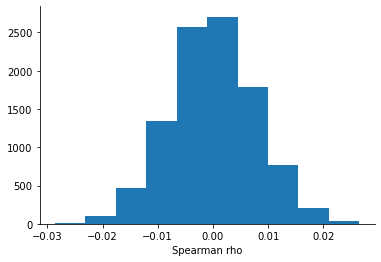

In [25]:
shuffled_corrs = [shuffle_spearman(df_plot.PFAM_share, df_plot.num_GO_overlap) for _ in range(10000)]

# cool, so it is significant
plt.hist(shuffled_corrs)
sns.despine()
#plt.axvline(test_val[0], color="purple")
plt.xlabel("Spearman rho")
plt.show()

In [26]:
# significant because the sample size is so large. But at least the correlation coefficient is not that close to 0
p_val = np.sum(np.abs(shuffled_corrs) > np.abs(test_val[0])) / len(shuffled_corrs)
p_val

0.0